In [2]:
import numpy as np
import time
from pyDOE import lhs
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
import scipy.io
import random
import torch
import torch.nn as nn

In [2]:
class MultiLayerPerceptronClass(nn.Module):
    """_summary_
    MultiLayerPerceptron
    
    This class is a simple implementation of a multi-layer perceptron (MLP) using PyTorch
    """
    def __init__(
        self,
        name        = 'mlp',
        x_dim       = 784,
        h_dim_list  = [256,256],
        y_dim       = 10,
        actv        = nn.ReLU(),
        p_drop      = 0.2,
        batch_norm  = True,
        output_list = False
    ):
        """
            Initialize MLP
        """
        super(MultiLayerPerceptronClass,self).__init__()
        self.name       = name
        self.x_dim      = x_dim
        self.h_dim_list = h_dim_list
        self.y_dim      = y_dim
        self.actv       = actv
        self.p_drop     = p_drop
        self.batch_norm = batch_norm
        self.output_list= output_list
        
        # Declare layers
        self.layer_list = []
        h_dim_prev = self.x_dim
        for h_dim in self.h_dim_list:
            # dense -> batchnorm -> actv -> dropout
            self.layer_list.append(nn.Linear(h_dim_prev,h_dim))
            if self.batch_norm: self.layer_list.append(nn.BatchNorm1d(num_features=h_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(nn.Dropout1d(p=self.p_drop))
            h_dim_prev = h_dim
        self.layer_list.append(nn.Linear(h_dim_prev,self.y_dim))
        
        # Define net
        self.net = nn.Sequential()
        self.layer_names = []
        for l_idx,layer in enumerate(self.layer_list):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            self.net.add_module(layer_name,layer)
        
        # Initialize parameters
        self.init_param(VERBOSE=False)
        
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.BatchNorm1d): # init BN
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
        
    def forward(self,x):
        """
            Forward propagate
        """

        if self.output_list:
            intermediate_output_list = []
            for idx, layer in enumerate(self.net):
                x = layer(x)
                intermediate_output_list.append(x)
            # Final output
            final_output = x   
            return final_output, intermediate_output_list
        
        else:
            for idx, layer in enumerate(self.net):
                x = layer(x)
                intermediate_output_list.append(x)
            # Final output
            final_output = x
            return final_output

In [ ]:
class PINN_Laminar_Flow(nn.Module):
    def __init__(self, Collo, INLET, OUTLET, WALL, uv_layers, lb, ub, rho=1.0, mu=0.02, uv_model_path=None):
        super(PINN_Laminar_Flow, self).__init__()
        # Domain bounds를 텐서로 변환
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)
        
        # 물리적 상수
        self.rho = rho  # 밀도
        self.mu = mu  # 점성
        
        # Collocation points, INLET, OUTLET, WALL을 텐서로 변환
        self.x_c = torch.tensor(Collo[:, 0:1], dtype=torch.float32)
        self.y_c = torch.tensor(Collo[:, 1:2], dtype=torch.float32)
        self.INLET = torch.tensor(INLET, dtype=torch.float32)
        self.OUTLET = torch.tensor(OUTLET, dtype=torch.float32)
        self.WALL = torch.tensor(WALL, dtype=torch.float32)
        
        # 신경망 구성
        self.uv_net = MultiLayerPerceptronClass(
            x_dim=2, # for x, y
            h_dim_list=uv_layers, # hidden layers dimensions
            y_dim=5, # for u, v, p, s11, s22, s12
            actv=nn.ReLU(),
            p_drop=0.2,
            batch_norm=True
        )
        if uv_model_path is not None:
            self.uv_net.load_state_dict(torch.load(uv_model_path))

        # 손실 기록
        self.loss_rec = []
    
    # Define additional methods like net_uv, net_f, train, predict based on the provided MLP class
    def forward(self, x, y):
        # Implementation based on self.forward
        xy = torch.cat([x, y], dim=1)  # 입력 데이터를 결합합니다.
        uv_pred, _ = self.uv_net(xy)  # 수정된 MLP를 사용하여 예측을 수행합니다.

        # uv_pred에서 u, v, p, s11, s22, s12 값을 분리합니다.
        psi = uv_pred[:,0:1]
        p = uv_pred[:,1:2]
        s11 = uv_pred[:, 2:3]
        s22 = uv_pred[:, 3:4]
        s12 = uv_pred[:, 4:5]
        
        # PyTorch에서는 자동 미분을 사용하여 u, v에 대한 미분을 직접 계산할 수 있습니다.
        psi = uv_pred[:, -1].unsqueeze(-1)  # 마지막 차원 확장
        u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
        v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
        # .sum()을 사용하는 것은 벡터 출력에 대한 미분을 스칼라로 변환하여 계산하기 위한 것이며,
        # grad_outputs=torch.ones_like(...) 부분이 없는 것은 스칼라에 대한 미분을 계산할 때는 기본적으로 가중치가 1이라고 가정하기 때문
        return u, v, p, s11, s22, s12

    def net_f(self, x, y):
        # Implementation based on physical constraints
        # 먼저 net_uv를 호출하여 필요한 값들을 계산합니다.
        u, v, p, s11, s22, s12 = self.net_uv(x, y)

        # 자동 미분을 사용하여 미분을 계산합니다.
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        s11_x = torch.autograd.grad(s11, x, grad_outputs=torch.ones_like(s11), create_graph=True)[0]
        s12_y = torch.autograd.grad(s12, y, grad_outputs=torch.ones_like(s12), create_graph=True)[0]
        s22_y = torch.autograd.grad(s22, y, grad_outputs=torch.ones_like(s22), create_graph=True)[0]
        s12_x = torch.autograd.grad(s12, x, grad_outputs=torch.ones_like(s12), create_graph=True)[0]

        # 물리적 조건을 바탕으로 한 손실 함수 계산
        f_u = self.rho * (u * u_x + v * u_y) - (s11_x + s12_y)
        f_v = self.rho * (u * v_x + v * v_y) - (s12_x + s22_y)
        f_s11 = -p + 2 * self.mu * u_x - s11
        f_s22 = -p + 2 * self.mu * v_y - s22
        f_s12 = self.mu * (u_y + v_x) - s12

        # 압력에 대한 추가 항 계산이 필요할 수 있습니다.
        f_p = p + (s11 + s22) / 2

        return f_u, f_v, f_s11, f_s22, f_s12, f_p
    
    def train(self, num_epochs, learning_rate):
        # Implementation of training logic
        pass
    
    def predict(self, x, y):
        # Use the trained model for predictions
        pass
    
    def get_loss(self):
        # Calculate and return the current loss
        pass

In [3]:
def DelCylPT(XY_c, xc=0.0, yc=0.0, r=0.1):
    '''
    delete points within cylinder
    '''
    dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in XY_c])
    return XY_c[dst>r,:]

(49076, 2)
(1133, 2)
(251, 2)
(201, 2)


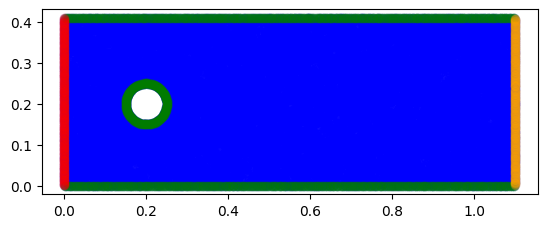

In [4]:
# Domain bounds
lb = np.array([0, 0])
ub = np.array([1.1, 0.41])

# Network configuration
MLP_input = 2
MLP_output = 5
MLP_hidden = 8*[40]

# WALL = [x, y], u=v=0
wall_up = [0.0, 0.41] + [1.1, 0.0] * lhs(2, 441)
wall_lw = [0.0, 0.00] + [1.1, 0.0] * lhs(2, 441)

# INLET = [x, y, u, v]
U_max = 1.0
INLET = [0.0, 0.0] + [0.0, 0.41] * lhs(2, 201)
y_INLET = INLET[:,1:2]
u_INLET = 4*U_max*y_INLET*(0.41-y_INLET)/(0.41**2)
v_INLET = 0*y_INLET
INLET = np.concatenate((INLET, u_INLET, v_INLET), 1)

# plt.scatter(INLET[:, 1:2], INLET[:, 2:3], marker='o', alpha=0.2, color='red')
# plt.show()

# INLET = [x, y], p=0
OUTLET = [1.1, 0.0] + [0.0, 0.41] * lhs(2, 201)

# Cylinder surface
r = 0.05
theta = [0.0] + [2*np.pi] * lhs(1, 251)
x_CYLD = np.multiply(r, np.cos(theta))+0.2
y_CYLD = np.multiply(r, np.sin(theta))+0.2
CYLD = np.concatenate((x_CYLD, y_CYLD), 1)

WALL = np.concatenate((CYLD, wall_up, wall_lw), 0)

# Collocation point for equation residual
XY_c = lb + (ub - lb) * lhs(2, 40000)
XY_c_refine = [0.1, 0.1] + [0.2, 0.2] * lhs(2, 10000)
XY_c = np.concatenate((XY_c, XY_c_refine), 0)
XY_c = DelCylPT(XY_c, xc=0.2, yc=0.2, r=0.05)

XY_c = np.concatenate((XY_c, WALL, CYLD, OUTLET, INLET[:,0:2]), 0)

print(XY_c.shape)
print(WALL.shape)
print(CYLD.shape)
print(OUTLET.shape)

# Visualize the collocation points
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(XY_c[:,0:1], XY_c[:,1:2], marker='o', alpha=0.1 ,color='blue')
plt.scatter(WALL[:,0:1], WALL[:,1:2], marker='o', alpha=0.2 , color='green')
plt.scatter(OUTLET[:, 0:1], OUTLET[:, 1:2], marker='o', alpha=0.2, color='orange')
plt.scatter(INLET[:, 0:1], INLET[:, 1:2], marker='o', alpha=0.2, color='red')
plt.show()